#  Разработка модели компьютерного зрения для обработки фотографий покупателей супермаркета

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 4)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path = '/datasets/faces/'
labels = pd.read_csv(path + 'labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
print('Количество дубликатов: ', labels.duplicated().sum())

Количество дубликатов:  0


In [5]:
print('Количество пропусков:\n', labels.isna().sum())

Количество пропусков:
 file_name    0
real_age     0
dtype: int64


Таким образом, в датасете 7591 объект, дубликатов и пропусков нет, все данные размечены - для каждого человека на фотографии указан его возраст.

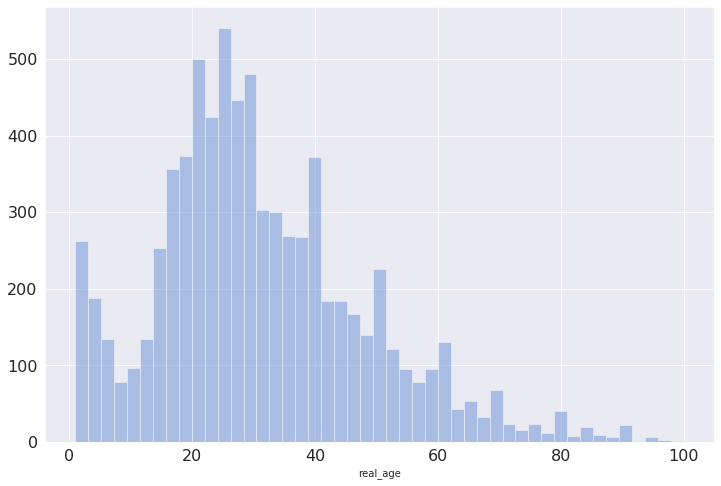

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(labels.real_age, hist=True, kde=False)
plt.show()

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера</b>

График отличный, только не хватает названия 😉

</div>


In [7]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

В датасете представлены люди от 1 до 100 лет, каких-либо аномальных значений нет. В выборке много фотографий детей возрастом до 7 лет - скорее всего они не покупают овощи и фрукты в супермаркете самостоятельно) Вероятно, можно было бы их удалить из выборки, чтобы не тратить на них машинные ресурсы. Здесь пока оставляю как есть.

При этом аспределение людей на фото по возрасту в целом похоже на нормальное, но немного скошено влево в сторону среднего возраста 29-30 лет. 

Посмотрим на фотографии:

Размер фотографии в пикселях:  (784, 784, 3) 
где 3 - означает три слоя RGB


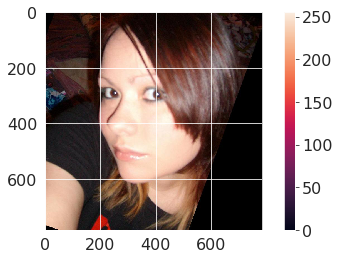

In [8]:
# здесь в пути можно прописать имя интересующей
image = Image.open(path + '/final_files/000001.jpg')
array = np.array(image)
print('Размер фотографии в пикселях: ', array.shape, '\nгде 3 - означает три слоя RGB')
plt.imshow(array)
plt.colorbar()
plt.show()

Так выведем матрицу из nxn фотографий:

In [10]:
# создадим генератор
datagen = ImageDataGenerator(validation_split=0.25,
                             rescale=1./255)

train_datagen_flow = datagen.flow_from_dataframe(
        directory=path + '/final_files/',
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150), # приводим все изображения к этому размеру
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

Found 5694 validated image filenames.


In [11]:
# получим объект с парой «картинки — метки»
features, target = next(train_datagen_flow)
print('Итого в этом объекте 16 изображений, размером 150х150 с тремя \nцветовыми каналами: ', features.shape)

Итого в этом объекте 16 изображений, размером 150х150 с тремя 
цветовыми каналами:  (16, 150, 150, 3)


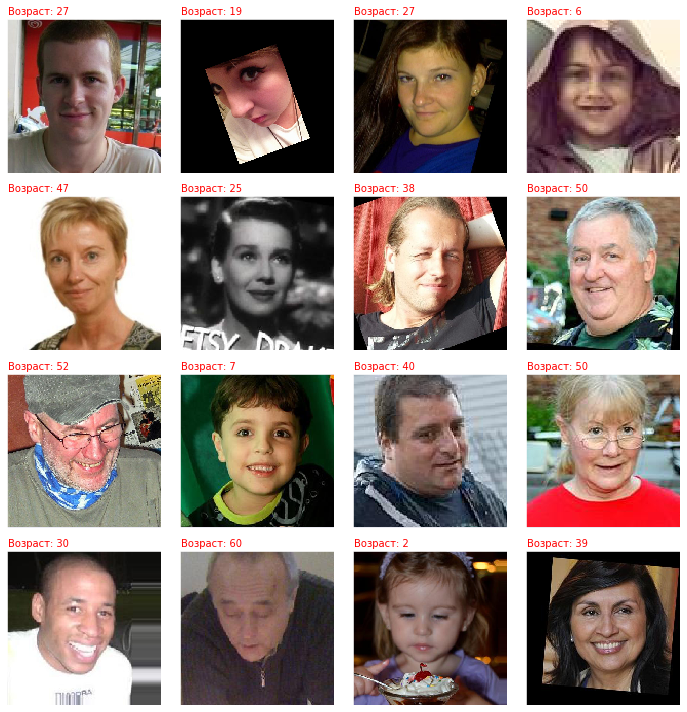

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.text(x=0, y=-5, s='Возраст: ' + str(target[i]), color='red')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В целом возраст указан правильно. Встеречались ошибки в разметке, где, например, на фотографии несколько человек и разметка указывает, что на фото человеку 7 лет. От такого надо бы почистить датасет, чтобы не получить Garbage In, Garbage Out. Сейчас просто понадеемся, что таких ошибок в данных мало и двинемся дальше.

# 2. Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# импорт библиотек
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np

# модель
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True, 
                                       width_shift_range=0.1,
                                       height_shift_range=0.1)
    # путь к файлу с разметкой path = '/datasets/faces/'
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                    dataframe=labels,
                                    directory=path + 'final_files/',
                                    x_col='file_name',
                                    y_col='real_age',
                                    target_size=(150, 150),
                                    batch_size=16,
                                    subset='training',
                                    class_mode='raw',        
                                    seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255)
    
    # путь к файлу с разметкой path = '/datasets/faces/'
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
                                    dataframe=labels,
                                    directory=path + 'final_files/',
                                    x_col='file_name',
                                    y_col='real_age',
                                    target_size=(150, 150),
                                    batch_size=16,
                                    subset='validation',
                                    class_mode='raw',        
                                    seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    # замораживаем ResNet50, чтобы избежать переобучения
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mse', 
                  metrics=['mae'])
    
    return model

def train_model(model, train_datagen_flow, test_datagen_flow, 
                batch_size=None, 
                epochs=3, 
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```
Epoch 1/3

356/356 - 160s - loss: 235.6916 - mae: 11.1270 - val_loss: 360.4427 - val_mae: 14.1470

Epoch 2/3

356/356 - 67s - loss: 106.6950 - mae: 7.9467 - val_loss: 154.6280 - val_mae: 9.2277

Epoch 3/3

356/356 - 66s - loss: 87.6584 - mae: 7.2041 - val_loss: 104.6980 - val_mae: 7.4244

Test MAE: 7.4244

```

# 3. Анализ обученной модели

Таким образом, применение ResNet50 сети даёт результат со средним абсолютным отклонением в 7.4 года. 

С одной стороны уже неплохо (иногда человек, я например, даёт оценку возраста с большим отклонением :), с другой стороны для решения задачи контроля продаж алкоголя кассирами несовершеннолетним (до 18 лет) этого явно недостаточно. Т.к. за это нарушение предусмотрен не только штраф, но и уголовная ответственность. И лучше, чтобы 7.4 года модельные, не превратились в реальные =))

Что можно сделать?
1. Улучшить данную модель дополнительными аугментациями, снижением learning rate, очисткой датасета от шума.
1. Попробовать собрать/отфильтровать датасет именно с целевой аудиторией возрастом от 10 до 30 лет и обучить сеть на нём. 
1. Перейти от задачи регрессии к задаче классификации - где целевая переменная можно (1) или нельзя (0) совершить продажу алкоголя данному покупателю. Интуитивно кажется, что это задача проще, чем предсказывать точный возраст, но может быть и нет)
1. Ввести теневой сбор информации [как у Tesla](https://habr.com/ru/post/450796/) - когда сеть работает в теневом режиме, то она постоянно делает прогнозы и ошибочные (после корректирующей разметки) заново идут на вход для обучения. Здесь, если покупатель так сказать из группы риска, то скорее всего он расплачивается картой/телефоном/кольцом и было бы здорово настроить пайплайн для автоматической разметки пары фотография-возраст путем запроса данных из банка о возрасте владельца карты.
1. Прикрутить к сети по распознованию возраста по фотографии сеть по распознаванию тональности голоса. Субъективно чувствую, что покупатели моложе 18 лет имеют особенности голоса :)